In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
labels_df = pd.read_csv('/content/drive/MyDrive/DL/labels.csv')
data_dir = '/content/drive/MyDrive/DL/traffic_Data/DATA'


In [4]:
images = []
labels = []

In [7]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [8]:
max_height = max(img.shape[0] for img in images)
max_width = max(img.shape[1] for img in images)

In [9]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [10]:
images = np.array(resized_images)
labels = np.array(labels)

In [12]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [13]:
oversampled_images = []
oversampled_labels = []

In [14]:
for label, count in zip(unique_labels, label_counts):
    label_images = images[oversampled_labels == label]
    num_to_duplicate = max_count - count
    if num_to_duplicate > 0:
        oversampled_images.extend(label_images)
        oversampled_labels.extend([label] * num_to_duplicate)

In [15]:
print(images.shape , labels.shape)

(4173, 224, 224, 3) (4173,)


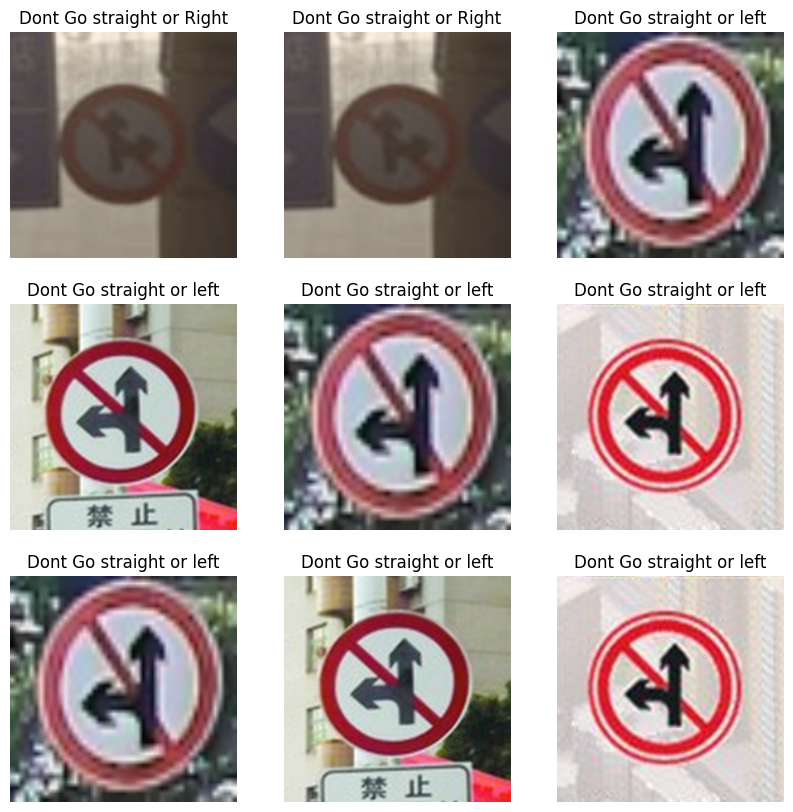

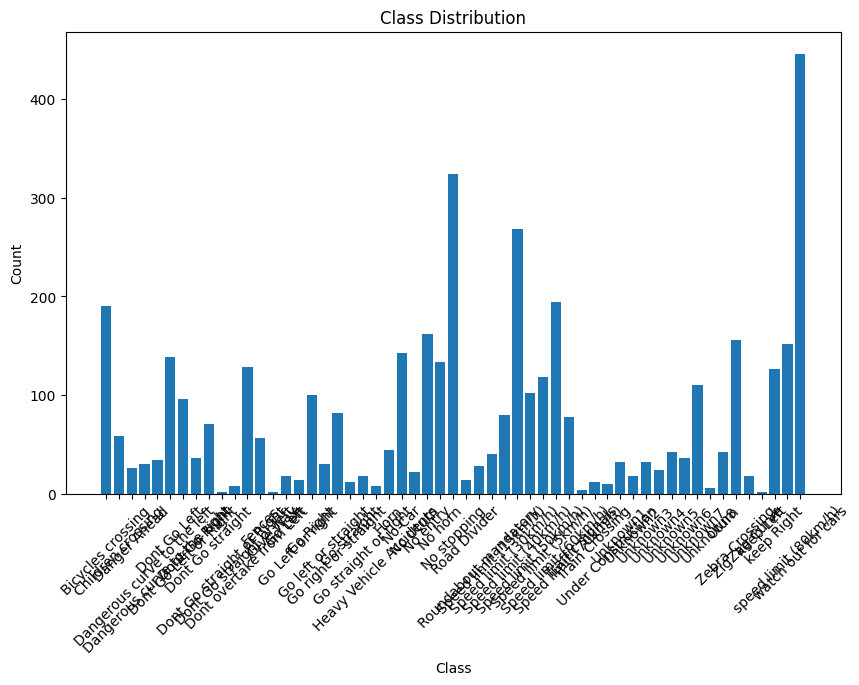

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [17]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


87910968/87910968 [==============================] - 1s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)

In [20]:
output = Dense(len(unique_labels), activation='softmax')(x)

In [21]:
inception_model = Model(inputs=base_model.input, outputs=output)


In [22]:
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [24]:
checkpoint_path = "inception_model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [25]:
X_resized = np.array(resized_images)
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
history = inception_model.fit(X_train_resized, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_resized, y_test_encoded),
                    callbacks=[checkpoint_callback])


Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 10.4861 - accuracy: 0.2825
Epoch 1: val_loss improved from inf to 4.56125, saving model to inception_model_weights.h5
105/105 [==============================] - 528s 5s/step - loss: 10.4861 - accuracy: 0.2825 - val_loss: 4.5612 - val_accuracy: 0.3796
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 2.8457 - accuracy: 0.4925
Epoch 2: val_loss improved from 4.56125 to 2.27992, saving model to inception_model_weights.h5
105/105 [==============================] - 508s 5s/step - loss: 2.8457 - accuracy: 0.4925 - val_loss: 2.2799 - val_accuracy: 0.5198
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 1.6737 - accuracy: 0.6004
Epoch 3: val_loss improved from 2.27992 to 1.75524, saving model to inception_model_weights.h5
105/105 [==============================] - 509s 5s/step - loss: 1.6737 - accuracy: 0.6004 - val_loss: 1.7552 - val_accuracy: 0.6036
Epoch 4/10
105/105 [=============

In [28]:
test_loss, test_acc = inception_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

27/27 [==============================] - 96s 3s/step - loss: 0.6879 - accuracy: 0.8467
Test Accuracy: 0.8467065691947937


In [29]:
layer_outputs = [layer.output for layer in inception_model.layers]
activation_model = Model(inputs=inception_model.input, outputs=layer_outputs)
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)

1/1 [==============================] - 6s 6s/step


In [31]:
# Define the number of images to display from each layer
num_images_per_layer = 3

# Iterate over the layers and activations
for layer_name, activation in zip(inception_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        num_channels = activation.shape[-1]
        num_displayed = min(num_images_per_layer, num_channels)
        fig, axes = plt.subplots(1, num_displayed, figsize=(15, 3))
        for i in range(num_displayed):
            axes[i].imshow(activation[0, :, :, i], cmap='viridis')  # Display activation for each channel
            axes[i].set_title(f'{layer_name.name} - Channel {i+1}')
            axes[i].axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

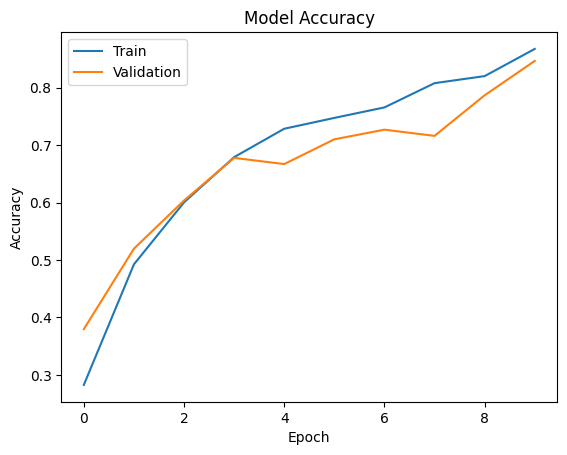

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


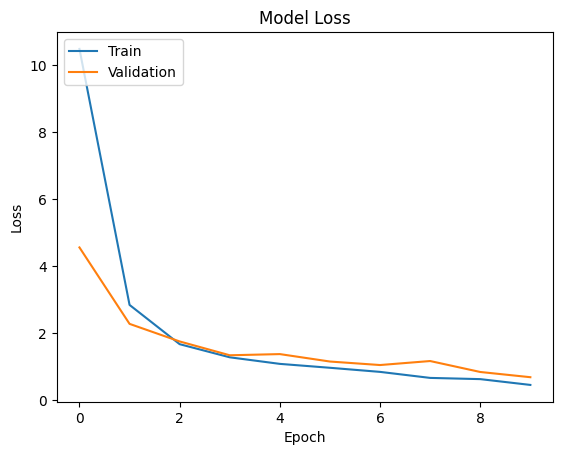

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


27/27 [==============================] - 99s 4s/step


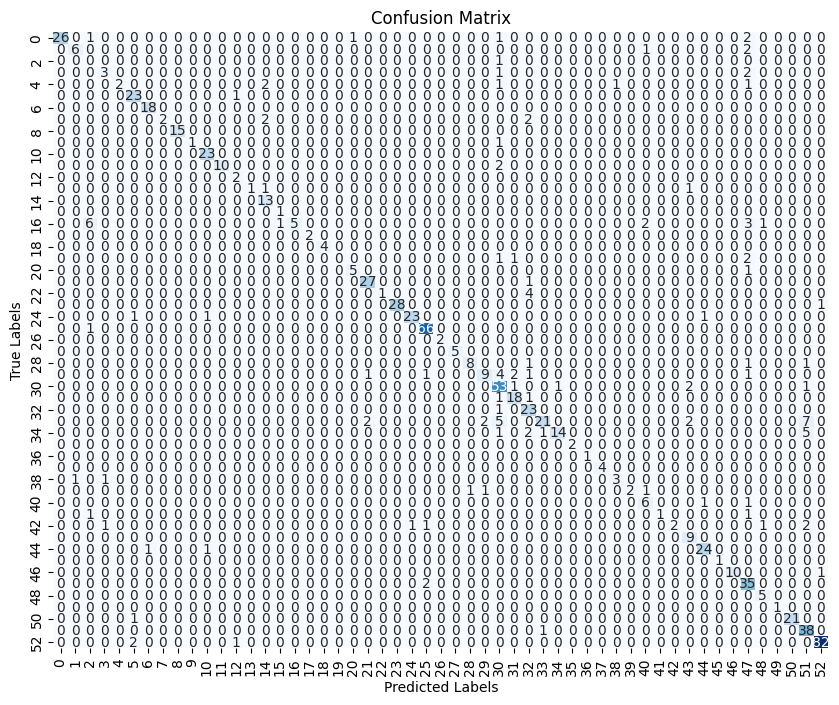

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        31
           1       0.86      0.67      0.75         9
           2       0.00      0.00      0.00         1
           3       0.60      0.50      0.55         6
           4       1.00      0.29      0.44         7
           5       0.85      0.96      0.90        24
           6       0.95      1.00      0.97        18
           7       1.00      0.33      0.50         6
           8       1.00      1.00      1.00        15
          10       1.00      0.50      0.67         2
          11       0.92      1.00      0.96        23
          12       1.00      0.83      0.91        12
          14       0.50      1.00      0.67         2
          15       1.00      0.33      0.50         3
          16       0.72      1.00      0.84        13
          17       0.50      1.00      0.67         1
          18       1.00      0.28      0.43        18
          19       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = inception_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test_encoded, y_pred_labels))


1/1 [==============================] - 0s 307ms/step


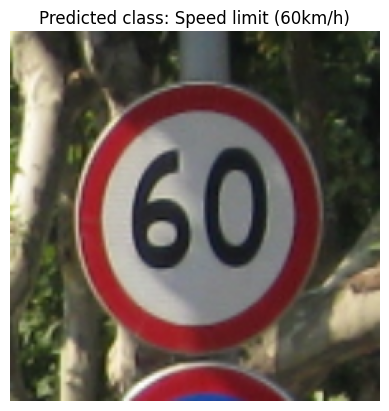

In [37]:
import matplotlib.pyplot as plt

# Choose a single test image
sample_image = X_test_resized[0]  # You can choose any index for the test image

# Reshape the image to match the model input shape
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Make prediction
prediction = inception_model.predict(sample_image)

# Decode the prediction (assuming label_encoder was used for encoding the class labels)
predicted_class_index = np.argmax(prediction)
predicted_class = label_encoder.classes_[predicted_class_index]

# Display the image
plt.imshow(X_test_resized[0])
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()
